# New Climate Features

## Imports

In [1]:
import xarray as xr
import pandas as pd
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from metpy.calc import advection
from metpy.units import units


In [2]:
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

c:\Users\marti\Desktop\data\hw_extra


In [4]:
from IndexDrivers import (
    AnomaliesIndex,
    MaxIndex, 
    calculate_anomalies
)
from PredictorsDrivers import (
    Predictor
)

## Code

### Preprocess Extra Indices

Let's preprocess the extra indices for ML. We use here DMI (Dipole Mode Index), ONI (Oceanic Niño Index), PDO (Pacific Decadal Oscillation), ENSO3.4 and 1+2 and SAM.

In [5]:
df_oni = pd.read_csv("data/extra_indices/oni.txt",sep="   |  | ", header=None, engine="python", names=["Season", "Year", "sst", "ONI"])
df_pdo = pd.read_csv("data/extra_indices/pdo.dat",sep="  | ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_sam = pd.read_csv("data/extra_indices/sam.txt",sep="  | ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
# df_meiv2 = pd.read_csv("data/extra_indices/meiv2.data",sep="     |    ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_enso34 = pd.read_csv("data/extra_indices/nino34.anom.data",sep="     |    |   ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_enso12 = pd.read_csv("data/extra_indices/nino12.anom.data",sep="     |    |   ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_dmi = pd.read_csv("data/extra_indices/dmi.data",sep="     |    ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])

In [6]:
def preprocess_df(df, name):
    df = df.melt(id_vars=['Year'], var_name='Month', value_name=name)
    df["Month"] = pd.to_numeric(df["Month"])
    df = df.sort_values(['Year','Month'])

    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
    df.set_index("Date", inplace=True)
    df.drop(columns=["Year", "Month"],inplace=True)
    return df

In [7]:
df_oni = pd.read_csv("data/extra_indices/oni.txt",sep="   |  | ", header=None, engine="python", names=["Season", "Year", "sst", "ONI"])
df_pdo = pd.read_csv("data/extra_indices/pdo.dat",sep="  | ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_sam = pd.read_csv("data/extra_indices/sam.txt",sep="  | ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
# df_meiv2 = pd.read_csv("data/extra_indices/meiv2.data",sep="     |    ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_enso34 = pd.read_csv("data/extra_indices/nino34.anom.data",sep="     |    |   ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_enso12 = pd.read_csv("data/extra_indices/nino12.anom.data",sep="     |    |   ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_dmi = pd.read_csv("data/extra_indices/dmi.data",sep="     |    ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])

season_to_month = {
    "DJF": "02", "JFM": "03", "FMA": "04", "MAM": "05",
    "AMJ": "06", "MJJ": "07", "JJA": "08", "JAS": "09",
    "ASO": "10", "SON": "11", "OND": "12", "NDJ": "01"
}
df_oni["Year"] = df_oni.apply(lambda row: row["Year"] + 1 if row["Season"] == "NDJ" else row["Year"], axis=1)
df_oni["month"] = df_oni["Season"].map(season_to_month)
df_oni["Date"] = pd.to_datetime(df_oni["Year"].astype(str) + "-" + df_oni["month"])

# Select required columns
df_oni = df_oni[["Date", "ONI"]]
df_oni.set_index("Date", inplace=True)

df_pdo = preprocess_df(df_pdo, "PDO")
df_sam = preprocess_df(df_sam, "SAM")
# df_meiv2 = preprocess_df(df_meiv2, "MEI")
df_enso34 = preprocess_df(df_enso34, "ENSO34")
df_enso12 = preprocess_df(df_enso12, "ENSO12")
df_dmi = preprocess_df(df_dmi, "DMI")

In [8]:
df_pdo = df_pdo[(df_pdo.index.year >= 1972) & (df_pdo.index.year <=2022)]
df_oni = df_oni[(df_oni.index.year >= 1972) & (df_oni.index.year <=2022)]
df_sam = df_sam[(df_sam.index.year >= 1972) & (df_sam.index.year <=2022)]
# df_meiv2 = df_meiv2[(df_meiv2.index.year >= 1972) & (df_meiv2.index.year <=2022)]
df_enso34 = df_enso34[(df_enso34.index.year >= 1972) & (df_enso34.index.year <=2022)]
df_enso12 = df_enso12[(df_enso12.index.year >= 1972) & (df_enso12.index.year <=2022)]
df_dmi = df_dmi[(df_dmi.index.year >= 1972) & (df_dmi.index.year <=2022)]



### Definition of Predictors

In [9]:
data_single = xr.load_dataset("data/local_data/7means_east_pacific.nc")
data_850 = xr.load_dataset("data/local_data/3means_850hpa_east_pacific.nc")
data_mslp = xr.load_dataset("data/local_data/MSLP_east_pacific.nc")
ref_period = [1980,2010]

### Advection

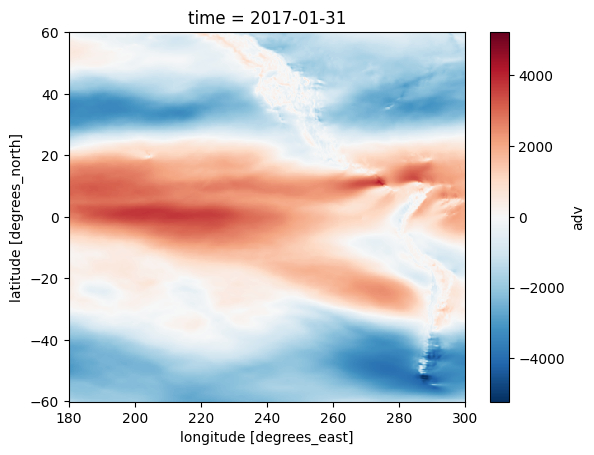

In [10]:
data_850["adv"] = -1*data_850.u*data_850.t
data_850.adv.sel(time="2017-01").plot()

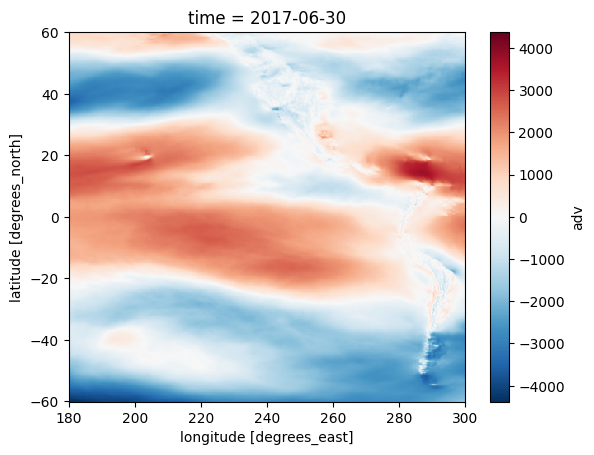

In [11]:
data_850.adv.sel(time="2017-06").plot()

### Pacific Predictors

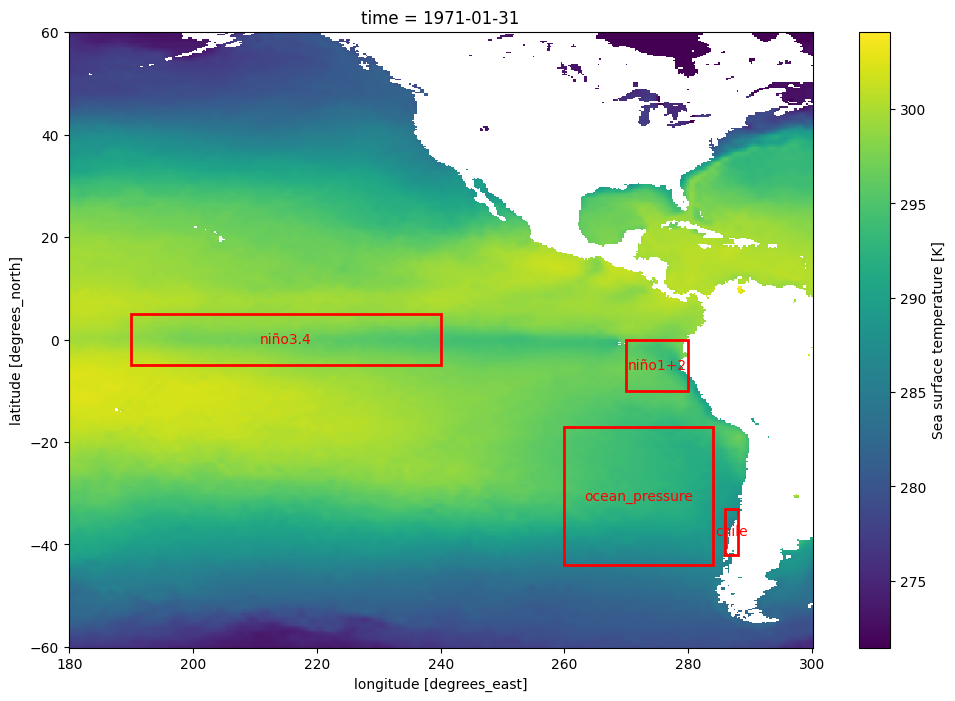

In [12]:
boxes_pacific = {
    "niño3.4": [190, 240, -5, 5],  # [lon_min, lon_max, lat_min, lat_max]
    "niño1+2": [270, 280, -10, 0],
    "ocean_pressure": [260, 284, -44, -17], #study max over time and define region
    "chile" : [286, 288, -42, -33]
    #"advección": [280, 285, -37, -30]
}

fig, ax = plt.subplots(figsize=(12, 8))

data_single.sst.isel(time=0).plot(ax=ax)

for box_id, coords in boxes_pacific.items():
    lon_min, lon_max, lat_min, lat_max = coords
    width = lon_max - lon_min
    height = lat_max - lat_min
    
    # Create rectangle patch
    rect = mpatches.Rectangle((lon_min, lat_min), width, height,
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    # Optionally add a label
    ax.text(lon_min + width/2, lat_min + height/2, f"{box_id}", 
            ha='center', va='center', color='red')

plt.show()

In [13]:
nino34 = AnomaliesIndex(data_single, [1972,2022], reference_period=ref_period, variables=["SST"], box_limit=boxes_pacific["niño3.4"], rolling_window=1, frequency="monthly")
nino12 = AnomaliesIndex(data_single, [1972,2022], reference_period=ref_period, variables=["SST"], box_limit=boxes_pacific["niño1+2"], rolling_window=1, frequency="monthly")
chile_t = AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["T"], box_limit=boxes_pacific["chile"], rolling_window=1, frequency="monthly")
ocean_cyclone = MaxIndex(data_mslp, [1972,2022], variables=["MSL"], box_limit=boxes_pacific["ocean_pressure"], anomalies=True, climatology_period=ref_period)
pacific_indices = [nino34, nino12, chile_t, ocean_cyclone]


In [14]:
ids_pacific = [index.index_df_to_parquet(index.variables[0], "data/my_indices/","data/my_indices/metadata.csv") for index in pacific_indices]

Saved
Saved
Saved
Saved


In [15]:
pacific_indices = [nino34, nino12, chile_t, ocean_cyclone]

### Chile Wind Predictors (Raco + Puelche)

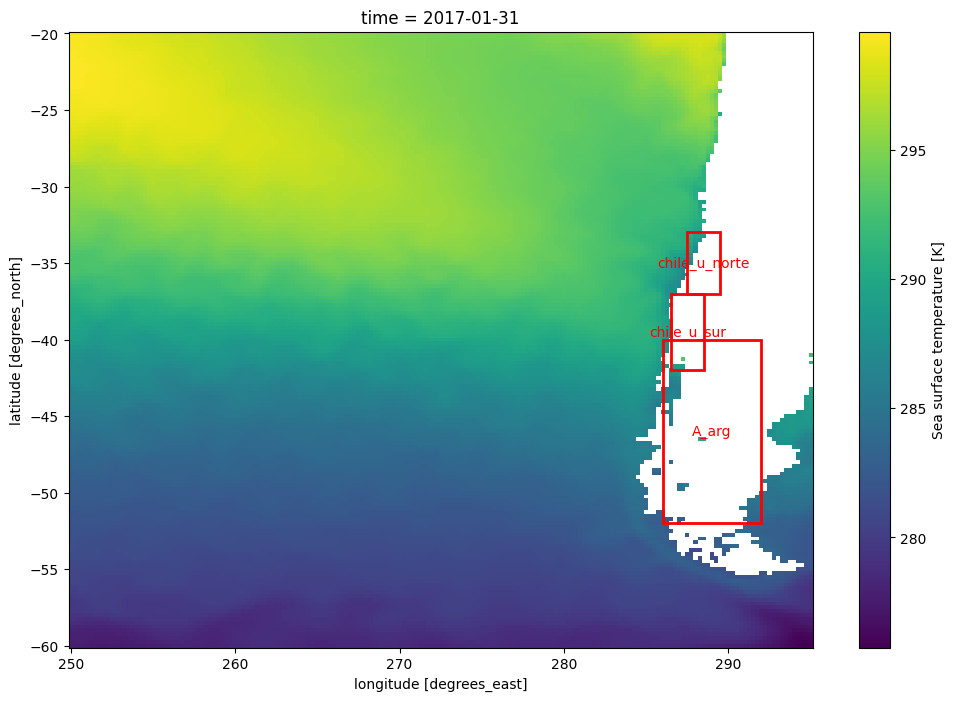

In [16]:
boxes_chile_winds = {
    "chile_u_norte": [287.5, 289.5, -37, -33],
    "chile_u_sur": [286.5, 288.5, -42, -37],
    "A_arg": [286, 292, -52, -40]
}

fig, ax = plt.subplots(figsize=(12, 8))

data_single.sel(longitude=slice(250,295), latitude=slice(-60,-20), time="2017-01").sst.plot(ax=ax)

for box_id, coords in boxes_chile_winds.items():
    lon_min, lon_max, lat_min, lat_max = coords
    width = lon_max - lon_min
    height = lat_max - lat_min
    
    # Create rectangle patch
    rect = mpatches.Rectangle((lon_min, lat_min), width, height,
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    # Optionally add a label
    ax.text(lon_min + width/2, lat_min + height/2, f"{box_id}", 
            ha='center', va='center', color='red')

plt.show()

In [17]:
wind_indices = [AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["U"], box_limit=boxes_chile_winds["chile_u_norte"], rolling_window=1, frequency="monthly"),
                AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["U"], box_limit=boxes_chile_winds["chile_u_sur"], rolling_window=1, frequency="monthly"),
                AnomaliesIndex(data_mslp, [1972,2022], reference_period=ref_period, variables=["MSL"], box_limit=boxes_chile_winds["A_arg"], rolling_window=1, frequency="monthly")]

In [18]:
ids_winds = [index.index_df_to_parquet(index.variables[0], "data/my_indices/","data/my_indices/metadata.csv") for index in wind_indices]

Saved
Saved
Saved


### Chile vaguada

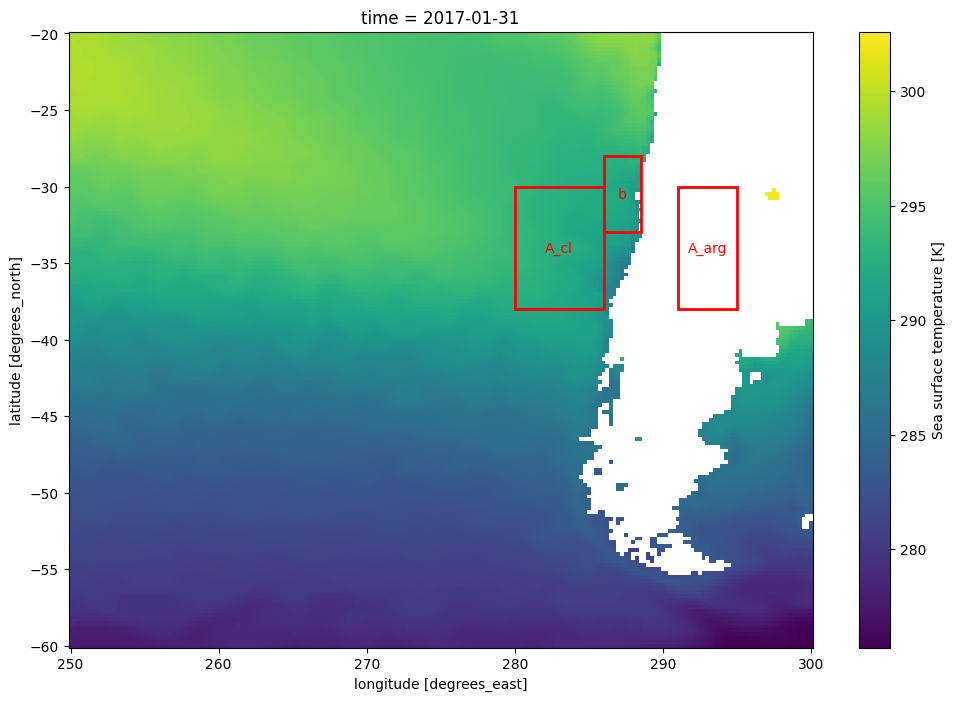

In [19]:
boxes_chile_vaguada = {
    "b": [286, 288.5, -33, -28],
    "A_cl": [280, 286, -38,-30], #test bigger A boxes
    "A_arg": [291, 295, -38, -30]
}

fig, ax = plt.subplots(figsize=(12, 8))

data_single.sel(longitude=slice(250,310), latitude=slice(-60,-20), time="2017-01").sst.plot(ax=ax)

for box_id, coords in boxes_chile_vaguada.items():
    lon_min, lon_max, lat_min, lat_max = coords
    width = lon_max - lon_min
    height = lat_max - lat_min
    
    # Create rectangle patch
    rect = mpatches.Rectangle((lon_min, lat_min), width, height,
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    # Optionally add a label
    ax.text(lon_min + width/2, lat_min + height/2, f"{box_id}", 
            ha='center', va='center', color='red')

plt.show()

In [20]:
mslp_indices = [AnomaliesIndex(data_mslp, [1972,2022], reference_period=ref_period, variables=["MSL"], box_limit=box, rolling_window=1, frequency="monthly") for key,box in boxes_chile_vaguada.items()]

In [21]:
ids_mslp = [index.index_df_to_parquet(index.variables[0], "data/my_indices/","data/my_indices/metadata.csv") for index in mslp_indices]

Saved
Saved
Saved


### Chile Advection

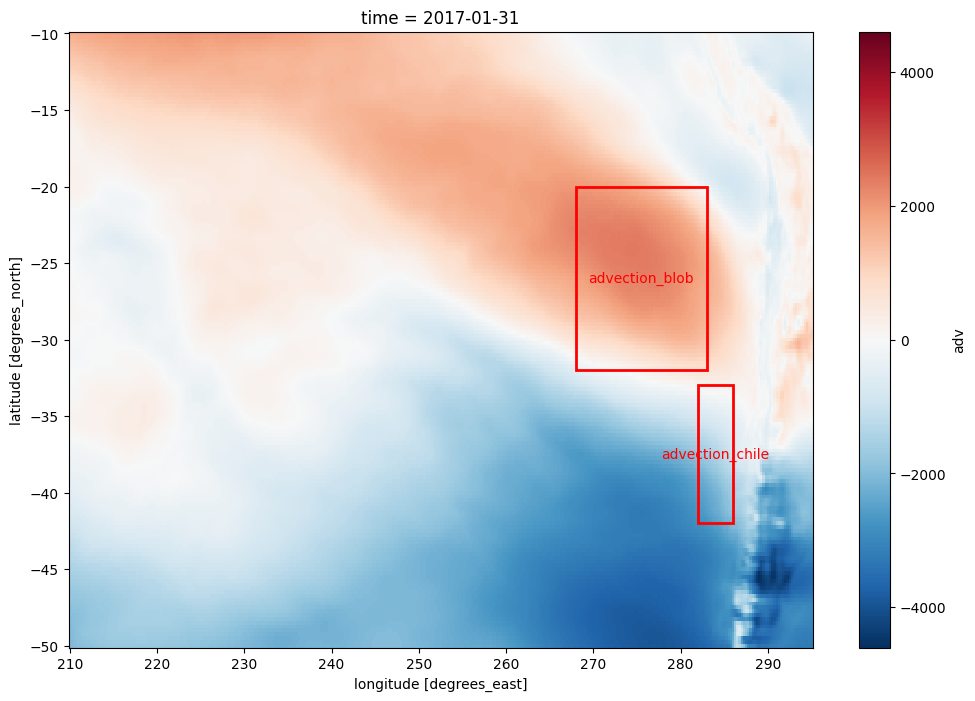

In [22]:
boxes_chile_adv = {
    "advection_chile": [282, 286, -42, -33],
    "advection_blob": [268, 283, -32, -20]
}

fig, ax = plt.subplots(figsize=(12, 8))

data_850.sel(longitude=slice(210,295), latitude=slice(-50,-10), time="2017-01").adv.plot(ax=ax)

for box_id, coords in boxes_chile_adv.items():
    lon_min, lon_max, lat_min, lat_max = coords
    width = lon_max - lon_min
    height = lat_max - lat_min
    
    # Create rectangle patch
    rect = mpatches.Rectangle((lon_min, lat_min), width, height,
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    # Optionally add a label
    ax.text(lon_min + width/2, lat_min + height/2, f"{box_id}", 
            ha='center', va='center', color='red')

plt.show()

In [23]:
advection_indices = [AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_chile"], rolling_window=1),
                     AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_blob"], rolling_window=1)]

In [24]:
ids_adv = [index.index_df_to_parquet(index.variables[0], "data/my_indices/","data/my_indices/metadata.csv") for index in advection_indices]

Saved
Saved


In [25]:
ids_adv

['57c4c65d', '8f223d89']

## Create Experiments

In [26]:
predictors = Predictor()
extra_indices_names = ["PDO", "ONI", "SAM", "DMI"]
extra_indices = [df_pdo, df_oni, df_sam, df_dmi]


In [28]:
my_indices_ids = ids_pacific + ids_winds + ids_mslp + ids_adv
Indices = pacific_indices + wind_indices + mslp_indices + advection_indices
my_indices = [index.get_index(index.variables[0]) for index in Indices]

In [29]:
# exp, num = predictors.incorporate_predictor(my_indices, my_indices_ids)
exp, num = predictors.incorporate_predictor(my_indices+extra_indices, my_indices_ids+extra_indices_names)

## Chile

In [30]:
hwis_chile= pd.read_csv(f"data/local_data/monthly/HWs_chile_central.csv")
hwis_chile["Date"] = pd.to_datetime(hwis_chile["Date"],format='%Y-%m')
hwis_chile.set_index('Date', inplace=True)
region="chile"

In [31]:
exp_label, num_label = predictors.incorporate_label(hwis_chile, num_exp=num)

In [32]:
predictors.experiment_to_parquet(num_label, f"data/climate_features/{region}/", f"data/climate_features/{region}/metadata.csv")

Saved


## California

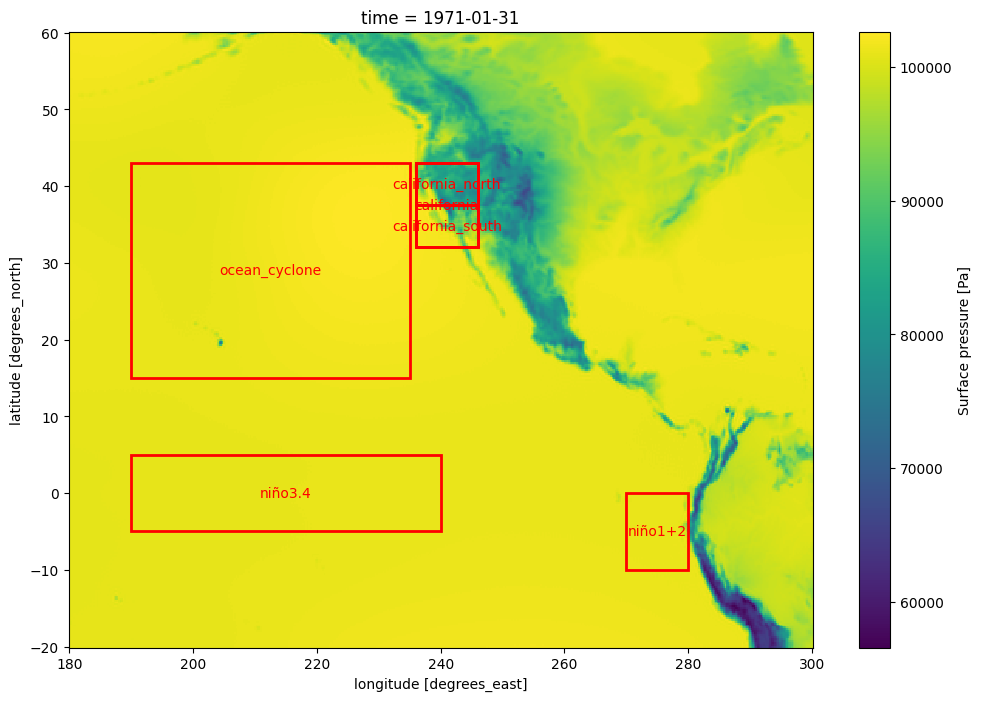

In [37]:
data = xr.load_dataset("data/local_data/7means_east_pacific.nc")

boxes = {
    "niño3.4": [190, 240, -5, 5],  # [lon_min, lon_max, lat_min, lat_max]
    "niño1+2": [270, 280, -10, 0],
    "california_north": [236, 246, 37.5, 43],
    "california_south": [236, 246, 32, 37.5],
    "california": [236,246, 32, 43],
    "ocean_cyclone": [190, 235, 15, 43],
}

fig, ax = plt.subplots(figsize=(12, 8))

data.sel(latitude=slice(-20, 60), longitude=slice(130, 300)).sp.isel(time=0).plot(ax=ax)

for box_id, coords in boxes.items():
    lon_min, lon_max, lat_min, lat_max = coords
    width = lon_max - lon_min
    height = lat_max - lat_min
    
    # Create rectangle patch
    rect = mpatches.Rectangle((lon_min, lat_min), width, height,
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    # Optionally add a label
    ax.text(lon_min + width/2, lat_min + height/2, f"{box_id}", 
            ha='center', va='center', color='red')

plt.show()

In [31]:
data = xr.load_dataset("data/local_data/7means_world.nc")

In [32]:
ref_period = [1980,2010]

In [33]:
nino34 = AnomaliesIndex(data, [1972,2022], reference_period=ref_period, variables=["SST"], box_limit=boxes["niño3.4"], rolling_window=1, frequency="monthly")
nino12 = AnomaliesIndex(data, [1972,2022], reference_period=ref_period, variables=["SST"], box_limit=boxes["niño1+2"], rolling_window=1, frequency="monthly")
Indices = [nino34, nino12, 
           AnomaliesIndex(data, [1972,2022], reference_period=ref_period, variables=["SP"], box_limit=boxes["california_north"], rolling_window=1, frequency="monthly"), 
           AnomaliesIndex(data, [1972,2022], reference_period=ref_period, variables=["SP"], box_limit=boxes["california_south"], rolling_window=1, frequency="monthly"),
           MaxIndex(data, [1972,2022], variables=["SP"], box_limit=boxes["ocean_cyclone"]),
           AnomaliesIndex(data, [1972,2022], reference_period=ref_period, variables=["U10"], box_limit=boxes["california"], rolling_window=1, frequency="monthly")]


In [34]:
ids = [index.index_df_to_parquet(index.variables[0], "data/my_indices/","data/my_indices/metadata.csv") for index in Indices]

Saved
Saved
Saved
Saved
Saved
Saved


In [37]:
predictors = Predictor()
extra_indices_names = ["PDO", "ONI", "SAM", "DMI"]
extra_indices = [df_pdo, df_oni, df_sam, df_dmi]

my_indices_ids = ids
my_indices = [index.get_index_by_variable(index.variables[0]) for index in Indices]
exp, num = predictors.incorporate_predictor(my_indices+extra_indices, my_indices_ids+extra_indices_names)

In [38]:
hwis_cali= pd.read_csv(f"data/local_data/monthly/HWs_california_NOAA.csv")
hwis_cali["Date"] = pd.to_datetime(hwis_cali["Date"],format='%Y-%m')
hwis_cali.set_index('Date', inplace=True)
region="california"

In [39]:
exp_label2, num_label2 = predictors.incorporate_label(hwis_cali, num_exp=num)

In [45]:
predictors.experiment_to_parquet(num_label2, f"data/climate_features/{region}/", f"data/climate_features/{region}/metadata.csv")

Saved
